/home/dieselim/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dieselim/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


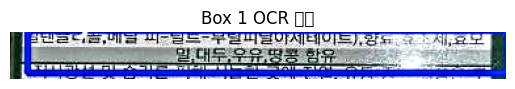


🔍 Box 1 OCR 텍스트 (원본): (튿이제레미트) 밀 대도 우유 땅콩 함유
✅ 정제 후 텍스트: 밀, 우유, 땅콩 함유
▶️ 음성 저장됨: tts_output_1.mp3


In [ ]:
import cv2
import easyocr
import matplotlib.pyplot as plt
from TTS.api import TTS
import os
import webbrowser

img_path = "/home/dieselim/yolov5/allergy_project/predictions_m_60_0.3/IMG_1472_jpeg.rf.7bea4cb10df7148006ef3698631ec1f2.jpg"  # 예측 결과 이미지 경로
label_path = "/home/dieselim/yolov5/dataset/labels/test/IMG_1472_jpeg.rf.7bea4cb10df7148006ef3698631ec1f2.txt"  # YOLO 라벨 경로

img = cv2.imread(img_path)
H, W, _ = img.shape

# 이미지 선명도 개선 (흐림 제거)
img_enhanced = cv2.detailEnhance(img, sigma_s=10, sigma_r=0.15)

reader = easyocr.Reader(['ko', 'en'])
tts_model = TTS(model_name="ko/tacotron2-DCTTS", progress_bar=False, gpu=False)

# YOLO 라벨 파일 읽고 OCR + 키워드 기반 보정
if os.path.exists(label_path):
    with open(label_path, "r") as f:
        lines = f.readlines()

    for i, line in enumerate(lines):
        parts = line.strip().split()
        cls, x_c, y_c, w, h = map(float, parts)

        # YOLO 좌표 → 픽셀 좌표 변환
        x1 = int((x_c - w/2) * W)
        y1 = int((y_c - h/2) * H)
        x2 = int((x_c + w/2) * W)
        y2 = int((y_c + h/2) * H)

        crop = img_enhanced[y1:y2, x1:x2]

        # crop 이미지 보기
        plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Box {i+1} OCR 대상")
        plt.show()

        # OCR 실행
        results = reader.readtext(crop)
        extracted_text = " ".join([res[1] for res in results])

        # 키워드 기반 필터링 및 보정
        keywords = ["밀", "대두", "우유", "땅콩"]
        filtered_words = [word for word in keywords if word in extracted_text]
        corrected_text = ", ".join(filtered_words) + " 함유"

        print(f"\n🔍 Box {i+1} OCR 텍스트 (원본): {extracted_text}")
        print(f"✅ 정제 후 텍스트: {corrected_text}")

        # TTS 실행
        tts_output_path = f"tts_output_{i+1}.wav"
        tts_model.tts_to_file(text=corrected_text, file_path=tts_output_path)
        print(f"▶️ 음성 저장됨: {tts_output_path}")
        os.system(f"start {tts_output_path}")
else:
    print("⚠️ YOLO 라벨 파일을 찾을 수 없습니다.")
